In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch as pt
from sklearn.model_selection import train_test_split
import os
import numpy as np
import chardet
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [5]:
# Caricamento del tokenizer e del modello pre-addestrato CodeBERT
tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=6)


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

In [6]:
dataframe = pd.read_csv("drive/MyDrive/Colab Notebooks/code smells tesi/Code_Smells_NLP-1/dataset/final_dataset.csv")


In [7]:
dataframe

,Component,CDSBP,CC,LC,LZC,RB,SC
0,/*\n * Licensed to the Apache Software Founda...,1,0,0,0,0,0
1,/*\n * Licensed to the Apache Software Founda...,0,0,0,0,0,1
2,/*\n * Licensed to the Apache Software Founda...,0,0,0,0,0,1
3,/*\n * Licensed to the Apache Software Founda...,0,0,0,0,0,1
4,/*\n * Licensed to the Apache Software Founda...,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2512,"/*\n * The Apache Software License, Version 1....",0,0,0,0,0,1
2513,"/*\n * The Apache Software License, Version 1....",0,0,0,0,0,1
2514,"/*\n * The Apache Software License, Version 1....",0,0,0,0,0,1
2515,"/*\n * The Apache Software License, Version 1....",0,0,0,0,0,1


In [8]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('italian'))

def remove_comments(code):
    # Rimuove i commenti su una singola riga
    code = re.sub(r'//.*', '', code)
    # Rimuove i commenti su più righe
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    # Rimuove le stopwords
    tokens = [word.lower() for word in code.split() if word.lower() not in stop_words]
    filtered_text = ' '.join(tokens)
    # Rimuoviamo gli import
    code = re.sub(r'import\s+.*?;', '', code, flags=re.DOTALL)
    # Rimuoviamo i package
    code = re.sub(r'package\s+.*?;', '', code, flags=re.DOTALL)
    #Rimuove \n e \t
    code = re.sub(r'[\n\t]', '', code)
    return code

for i in range(len(dataframe)):
    dataframe['Component'][i] = remove_comments(dataframe['Component'][i])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-8-ac4c11036a49>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Component'][i] = remove_comments(dataframe['Component'][i])


In [9]:
# Creazione X e y. X = dataset senza le etichette, y = etichette
dataframe2 = dataframe.drop(columns=['CDSBP','CC','LC','LZC','RB','SC'])
y = dataframe[['CDSBP','CC','LC','LZC','RB','SC']]

In [10]:
# Divisione in train, validation e test set
X_train, X_test, Y_train, Y_test = train_test_split(dataframe2, y, test_size=0.33, random_state=1)
# X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5, random_state=1)

In [11]:
# Tokenizzazione del set di addestramento
train_encodings = tokenizer(list(X_train['Component']), truncation=True, padding=True, max_length = 512)
train_labels = pt.tensor(Y_train.values)

# # Tokenizzazione del set di validazione
# val_encodings = tokenizer(list(X_val['Component']), truncation=True, padding=True, max_length = 512)
# val_labels = pt.tensor(Y_val.values)

# Tokenizzazione del set di test
test_encodings = tokenizer(list(X_test['Component']), truncation=True, padding=True, max_length = 512)
test_labels = pt.tensor(Y_test.values)

In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
import torch
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# Imposta la dimensione del batch desiderata
batch_size = 8

# Definizione del dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Conversione dei dati tokenizzati in tensori PyTorch
train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
train_labels = torch.tensor(Y_train.values).to(device)

val_inputs = torch.tensor(test_encodings['input_ids']).to(device)
val_labels = torch.tensor(Y_test.values).to(device)

# Creazione del dataset di addestramento
train_dataset = TensorDataset(train_inputs, train_labels)

# Creazione del dataset di validazione
val_dataset = TensorDataset(val_inputs, val_labels)

# Crea i dataloader con la nuova batch_size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Creazione dell'ottimizzatore
optimizer = AdamW(model.parameters(), lr=1e-5)

# Definizione della funzione di perdita
loss_function = nn.CrossEntropyLoss()

# Addestramento del modello
model.to(device)
model.train()

for epoch in range(10):
    for batch in train_dataloader:
        optimizer.zero_grad()

        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        labels = labels.float()

        outputs = model(inputs)
        logits = outputs.logits

        loss = loss_function(logits, labels)  # Calcola la loss tra logits e etichette
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1} - Loss: {loss.item()}")
        # Libera la memoria GPU
        del inputs, labels
        torch.cuda.empty_cache()




/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Loss: 1.9111090898513794
Epoch 1 - Loss: 1.8212525844573975
Epoch 1 - Loss: 1.8554236888885498
Epoch 1 - Loss: 1.768682599067688
Epoch 1 - Loss: 1.7143927812576294
Epoch 1 - Loss: 1.6485034227371216
Epoch 1 - Loss: 1.714442253112793
Epoch 1 - Loss: 1.5782122611999512
Epoch 1 - Loss: 1.6089134216308594
Epoch 1 - Loss: 1.534240484237671
Epoch 1 - Loss: 1.6509277820587158
Epoch 1 - Loss: 1.552940011024475
Epoch 1 - Loss: 1.22733473777771
Epoch 1 - Loss: 1.5618656873703003
Epoch 1 - Loss: 1.3872864246368408
Epoch 1 - Loss: 1.4513921737670898
Epoch 1 - Loss: 1.1701098680496216
Epoch 1 - Loss: 1.750418782234192
Epoch 1 - Loss: 1.4184812307357788
Epoch 1 - Loss: 1.5493724346160889
Epoch 1 - Loss: 1.3503639698028564
Epoch 1 - Loss: 1.7593984603881836
Epoch 1 - Loss: 1.1059355735778809
Epoch 1 - Loss: 1.6073906421661377
Epoch 1 - Loss: 1.7673120498657227
Epoch 1 - Loss: 1.3123120069503784
Epoch 1 - Loss: 1.6252379417419434
Epoch 1 - Loss: 1.5593863725662231
Epoch 1 - Loss: 1.927176237

In [14]:
from sklearn.metrics import accuracy_score, precision_score, jaccard_score, hamming_loss, f1_score

val_accuracy = 0
total_val_samples = 0
precision_avg = 0
jaccard_score_avg = 0
hamming_loss_score = 0
f1_score_avg = 0

for batch in val_dataloader:
    inputs = batch[0].to(device)
    labels = batch[1].to(device)

    val_outputs = model(inputs)
    val_predicted_labels = (val_outputs.logits.sigmoid() > 0.5).int()
    
    val_accuracy += (val_predicted_labels == labels).sum().item()
    precision_avg += precision_score(labels.cpu().numpy(), val_predicted_labels.cpu().numpy(), average='samples')
    jaccard_score_avg += jaccard_score(labels.cpu().numpy(), val_predicted_labels.cpu().numpy(), average='samples')
    hamming_loss_score += hamming_loss(labels.cpu().numpy(), val_predicted_labels.cpu().numpy())
    f1_score_avg += f1_score(labels.cpu().numpy(), val_predicted_labels.cpu().numpy(), average='samples')
    
    total_val_samples += len(inputs)
    # Free up GPU memory
    del inputs, labels, val_outputs, val_predicted_labels
    torch.cuda.empty_cache()

val_accuracy /= total_val_samples
precision_avg /= total_val_samples
jaccard_score_avg /= total_val_samples
hamming_loss_score /= total_val_samples
f1_score_avg /= total_val_samples

print(f"Validation Accuracy: {val_accuracy}")
print(f"Precision: {precision_avg}")
print(f"Jaccard Score: {jaccard_score_avg}")
print(f"Hamming Loss: {hamming_loss_score}")
print(f"F1 Score: {f1_score_avg}")


Validation Accuracy: 5.3742478941034895
Precision: 0.09363897484384848
Jaccard Score: 0.09363897484384848
Hamming Loss: 0.013050828032777496
F1 Score: 0.10267248295226637


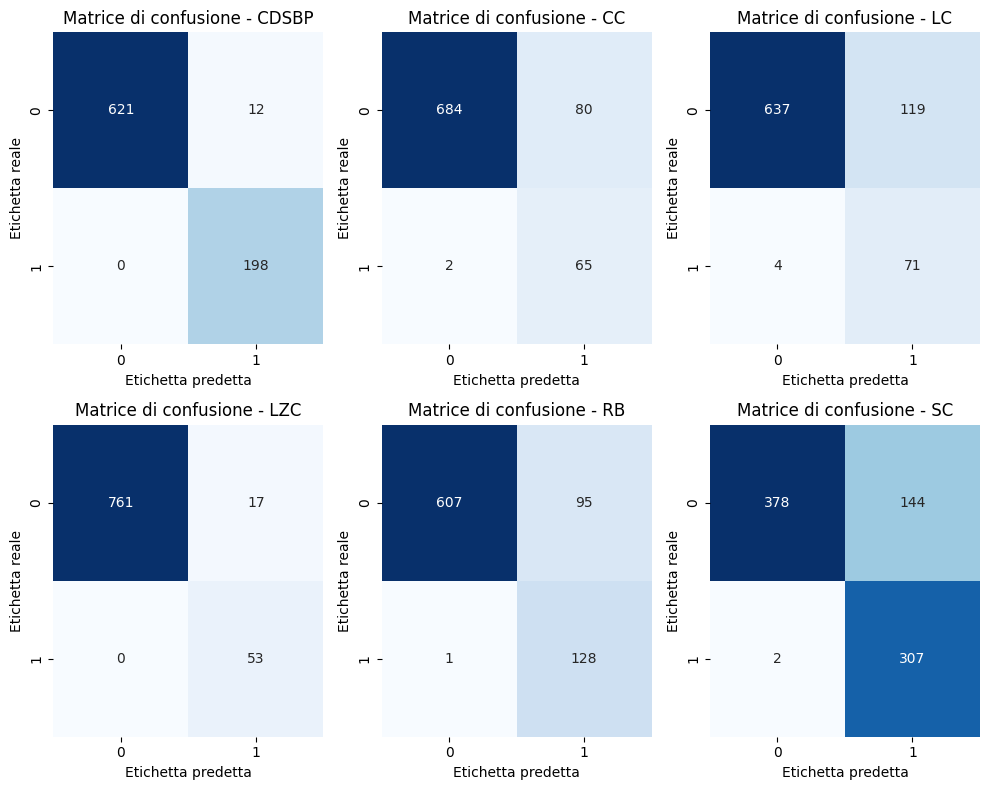

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Calcola le predizioni del modello sul dataset di validazione
model.eval()
with torch.no_grad():
    predicted_labels = []
    true_labels = []
    for batch in val_dataloader:
        inputs = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(inputs)
        predicted_labels.extend(outputs.logits.sigmoid().round().cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calcola la matrice di confusione
confusion_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

# Etichette delle classi
class_labels = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']

# Visualizza la matrice di confusione
plt.figure(figsize=(10, 8))
for i, cm in enumerate(confusion_matrix):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Etichetta predetta')
    plt.ylabel('Etichetta reale')
    plt.title(f'Matrice di confusione - {class_labels[i]}')
plt.tight_layout()
plt.show()
